# LABORATORIO 5
## Jhamil Crespo Rejas
## Ingenieria en Ciencias de la Computacion

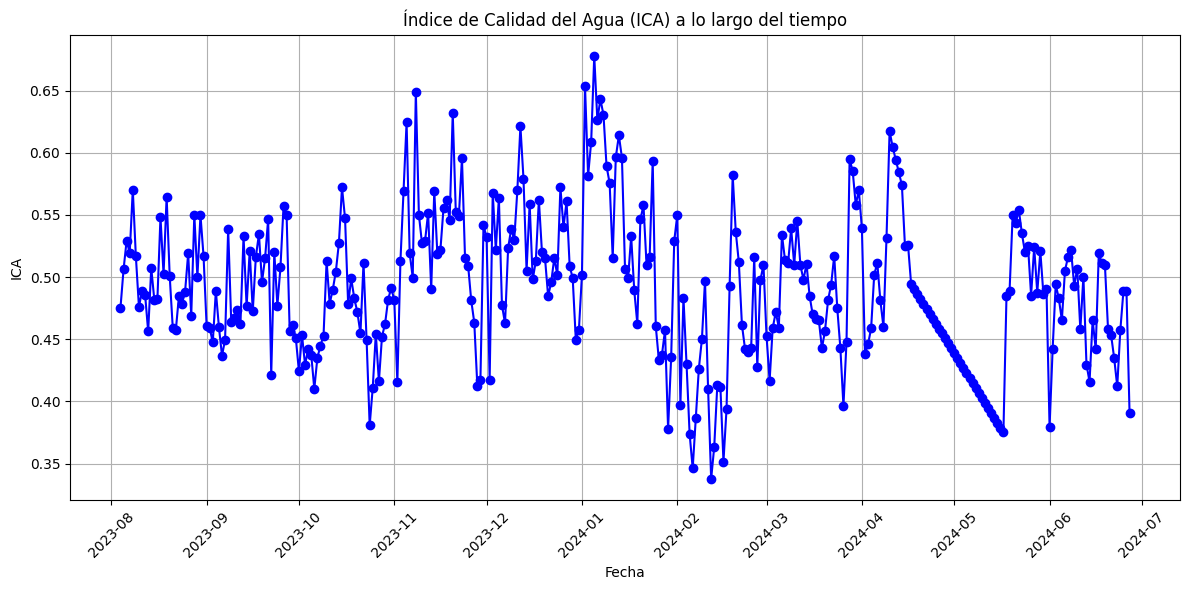

In [94]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Cargar el dataset
file_path = r"C:\Users\Jhamil\Desktop\IA2\csv\brisbane_water_quality_filled.csv"  # Cambia esta ruta por la ruta de tu archivo
dataset = pd.read_csv(file_path)

# Eliminar la columna 'ICA' y preparar el dataset
dataset_without_ica = dataset.drop(columns=['ICA'])
dataset_without_ica['Date'] = pd.to_datetime(dataset_without_ica['Date'])
dataset_without_ica = dataset_without_ica.sort_values(by='Date')

# Normalizar las características (excluyendo la columna 'Date')
scaler = MinMaxScaler()
features = dataset_without_ica.drop(columns=['Date'])
normalized_features = scaler.fit_transform(features)

# Convertir las características normalizadas de nuevo a un DataFrame
normalized_dataset = pd.DataFrame(normalized_features, columns=features.columns)


# Function to calculate the ICA based on predicted features
def calculate_ica(predictions):
    # Adjusted weights to match the number of features (10)
    weights = np.array([0.1, 0.2, 0.1, 0.1, 0.15, 0.1, 0.05, 0.05, 0.1, 0.05])  # Adjust weights for each feature
    ica_values = np.dot(predictions, weights)
    return ica_values

ica = calculate_ica(normalized_features)

# Graficar el ICA ordenado por fecha
plt.figure(figsize=(12, 6))
plt.plot(dataset_without_ica['Date'].values, ica, marker='o', linestyle='-', color='b')
plt.title('Índice de Calidad del Agua (ICA) a lo largo del tiempo')
plt.xlabel('Fecha')
plt.ylabel('ICA')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Crear secuencias de entrada y salida para LSTM
def create_sequences(data, time_steps):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:(i + time_steps)])
        y.append(data[i + time_steps])
    return np.array(X), np.array(y)

time_steps = 30  # Número de pasos de tiempo
X, y = create_sequences(normalized_dataset.values, time_steps)

# Convertir datos a tensores de PyTorch
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_val = torch.tensor(X_val, dtype=torch.float32)
y_val = torch.tensor(y_val, dtype=torch.float32)

In [95]:
import torch
import torch.nn as nn

class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=3, dropout_prob=0.5):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        # Definir la capa LSTM con múltiples capas
        self.lstm = nn.LSTM(
            input_size=input_size, 
            hidden_size=hidden_size, 
            num_layers=num_layers,  # Número de capas LSTM
            batch_first=True, 
            dropout=dropout_prob,  # Dropout entre capas, no a la salida final
            #bidirectional=False  # Puedes cambiar a True si quieres una LSTM bidireccional
        )
        
        # Capa fully connected para la salida
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x): #(batch_size, sequence_length, input_size)
        # Pasar por la LSTM
        _, (h_n, _) = self.lstm(x) #(num_layers * num_directions, batch_size, hidden_size)
        
        # Usar el último estado oculto de la última capa
        out = self.fc(h_n[-1]) #h_n es el tensor de estados ocultos finales para cada capa de la LSTM
        return out


# Inicializar el modelo, el criterio de pérdida y el optimizador
input_size = X_train.shape[2]
hidden_size = 50
output_size = y_train.shape[1]
model = LSTMModel(input_size, hidden_size, output_size)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-6)

Epoch 1/500, Training Loss: 0.2775, Validation Loss: 0.2791
Epoch 2/500, Training Loss: 0.2692, Validation Loss: 0.2705
Epoch 3/500, Training Loss: 0.2607, Validation Loss: 0.2620
Epoch 4/500, Training Loss: 0.2522, Validation Loss: 0.2533
Epoch 5/500, Training Loss: 0.2440, Validation Loss: 0.2444
Epoch 6/500, Training Loss: 0.2355, Validation Loss: 0.2351
Epoch 7/500, Training Loss: 0.2264, Validation Loss: 0.2251
Epoch 8/500, Training Loss: 0.2162, Validation Loss: 0.2144
Epoch 9/500, Training Loss: 0.2062, Validation Loss: 0.2025
Epoch 10/500, Training Loss: 0.1951, Validation Loss: 0.1893
Epoch 11/500, Training Loss: 0.1825, Validation Loss: 0.1745
Epoch 12/500, Training Loss: 0.1681, Validation Loss: 0.1578
Epoch 13/500, Training Loss: 0.1525, Validation Loss: 0.1391
Epoch 14/500, Training Loss: 0.1352, Validation Loss: 0.1189
Epoch 15/500, Training Loss: 0.1158, Validation Loss: 0.0983
Epoch 16/500, Training Loss: 0.0967, Validation Loss: 0.0802
Epoch 17/500, Training Loss: 0.07

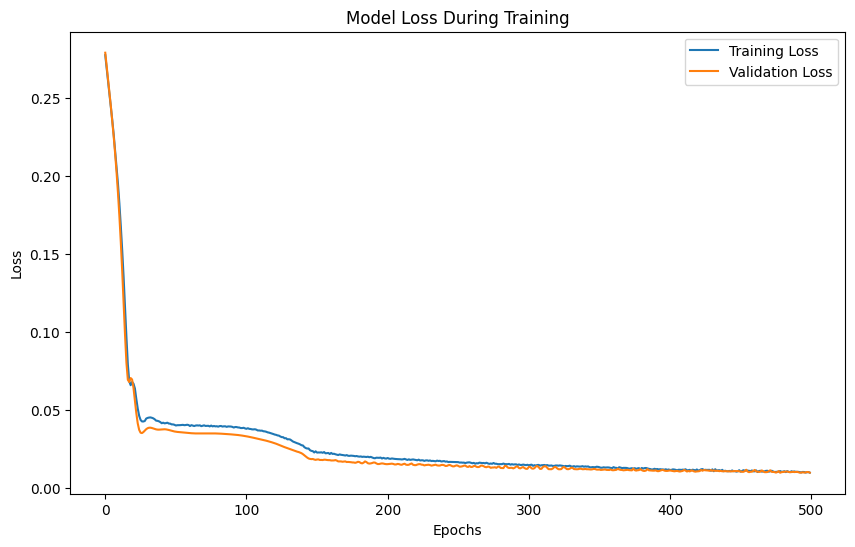

In [96]:
# Entrenar el modelo
epochs = 500
train_losses = []
val_losses = []

for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    output = model(X_train)
    loss = criterion(output, y_train)
    loss.backward()
    optimizer.step()
    train_losses.append(loss.item())

    # Validación
    model.eval()
    with torch.no_grad():
        val_output = model(X_val)
        val_loss = criterion(val_output, y_val)
        val_losses.append(val_loss.item())

    print(f"Epoch {epoch+1}/{epochs}, Training Loss: {loss.item():.4f}, Validation Loss: {val_loss.item():.4f}")

# Graficar la pérdida durante el entrenamiento
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Model Loss During Training')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [97]:
# Función para predecir desde la última fecha hasta una nueva fecha dada
def predict_future(model, start_input, num_predictions):
    model.eval()
    predictions = []
    current_input = start_input.clone()

    with torch.no_grad():
        for _ in range(num_predictions):
            prediction = model(current_input.unsqueeze(0))
            predictions.append(prediction.numpy().flatten())
            # Utilizar el valor predicho como el próximo input
            current_input = torch.cat((current_input[1:], prediction), dim=0)

    return np.array(predictions)

# Ejemplo de predicción futura
num_future_days = 30  # Cambia esto al número de días que deseas predecir
last_sequence = X_val[-1]  # Usar la última secuencia del conjunto de validación como punto de partida
future_predictions = predict_future(model, last_sequence, num_future_days)

# Mostrar predicciones futuras
print("Predicciones futuras:")
print(future_predictions)


Predicciones futuras:
[[0.5483988  0.5127895  0.21715385 0.52282214 0.43834704 0.54872525
  0.37370282 0.97202474 0.9649132  0.21679519]
 [0.55558693 0.51724154 0.22036766 0.52548265 0.44140422 0.551655
  0.3738746  0.9721256  0.9639889  0.2166846 ]
 [0.5618888  0.5212193  0.22322823 0.5285839  0.4442742  0.55459625
  0.37385768 0.972619   0.96318907 0.21614015]
 [0.5686248  0.52556336 0.22619838 0.53248286 0.447241   0.557962
  0.37338713 0.9734133  0.9624977  0.2152376 ]
 [0.57476175 0.52946544 0.22865053 0.53688073 0.44980597 0.5613812
  0.37249398 0.9743592  0.961795   0.21376772]
 [0.5833224  0.5350549  0.23220836 0.5423225  0.45327717 0.56568754
  0.37099838 0.9757803  0.9614986  0.21224765]
 [0.59351504 0.5420694  0.23676199 0.549018   0.4579224  0.5708529
  0.36892432 0.97823745 0.96215665 0.21047093]
 [0.6027472  0.54871094 0.24057868 0.55700314 0.46259987 0.5761744
  0.36615324 0.9816914  0.9638946  0.20773856]
 [0.6097468  0.55343556 0.24216129 0.565644   0.46556562 0.580649

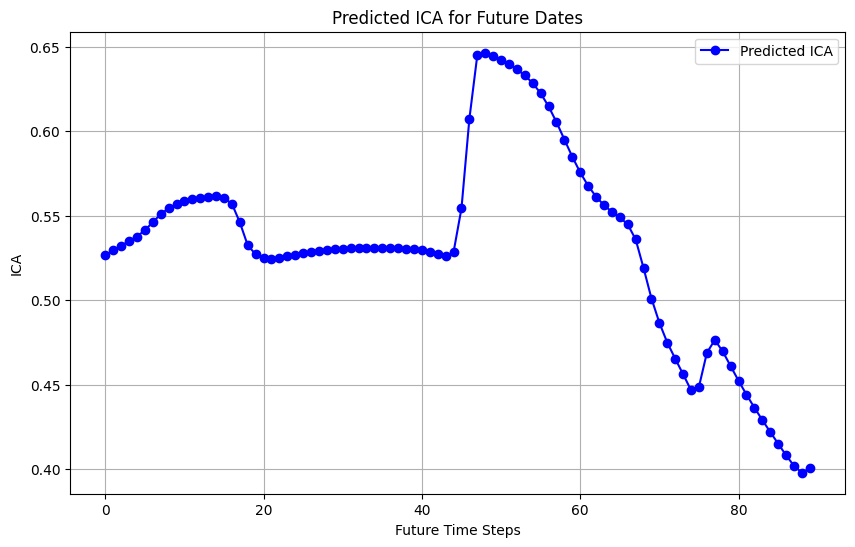

In [98]:
import numpy as np
import matplotlib.pyplot as plt

# Function to calculate the ICA based on predicted features
def calculate_ica(predictions):
    # Adjusted weights to match the number of features (10)
    weights = np.array([0.1, 0.2, 0.1, 0.1, 0.15, 0.1, 0.05, 0.05, 0.1, 0.05])  # Adjust weights for each feature
    ica_values = np.dot(predictions, weights)
    return ica_values

# Predict future values from the last sequence of validation set
num_future_days = 90  # Number of future days to predict
last_sequence = X_val[-1]  # Using the last sequence of validation data as the starting point
future_predictions = predict_future(model, last_sequence, num_future_days)

# Calculate the ICA for the future predictions
ica_predictions = calculate_ica(future_predictions)

# Plot the ICA predictions
plt.figure(figsize=(10, 6))
plt.plot(range(len(ica_predictions)), ica_predictions, marker='o', linestyle='-', color='b', label='Predicted ICA')
plt.title('Predicted ICA for Future Dates')
plt.xlabel('Future Time Steps')
plt.ylabel('ICA')
plt.legend()
plt.grid(True)
plt.show()
